In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from IPython.display import Audio
import IPython.display as ipd
from scipy.io import wavfile
import tempfile
import os
import librosa
import pandas as pd
import seaborn as sns
import h5py
import mne
from scipy.stats import zscore
from mne_bids import BIDSPath, read_raw_bids
from matplotlib_venn import venn2,venn2_circles
from tqdm import tqdm

In [5]:
cm = 1/2.54
plt.rcParams['svg.fonttype'] = 'none'

fontdict = dict(fontsize=7)
fontsize = 7

red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

stg_color = '#20B2AA'
smc_color = '#6A5ACD'
insula_color = '#D4AF37'

reds = sns.light_palette(red, as_cmap=True)
blues = sns.light_palette(blue, as_cmap=True)
oranges = sns.light_palette(orange, as_cmap=True)
greens = sns.light_palette(green, as_cmap=True)

recon_dir = '/cwork/ns458/ECoG_Recon/'
mne.viz.set_3d_backend('notebook')                    # MNE 3D in-notebook static backend
# text svg

Using notebook 3d backend.


# Load Connectivity

In [6]:
ref = 'bipolar'
task = ['LexicalDelay', 'PhonemeSequence']

paths = []
for t in task:
    paths.extend(
        BIDSPath(
            root=f'../results/{t}({ref})',
            datatype='connectivity',
            suffix='pdc',
            extension='.h5',
            check=False,
        ).match()
    )

def package_connectivity_frame(file_path: BIDSPath) -> pd.DataFrame:
    """Load connectivity results from HDF5 to pandas DataFrame in long format.
    
    Parameters
    ----------
    file_path : BIDSPath
        Path to the connectivity HDF5 file
        
    Returns
    -------
    df : pd.DataFrame
        Long-format DataFrame with columns:
        - subject, description, time, source, target, pdc, pval
    """
    import json
    
    with h5py.File(file_path.fpath, 'r') as f:
        pdc = f['pdc'][:]  # (n_windows, n_channels, n_channels)
        pvals = f['pvals'][:]
        time_points = f['time_points'][:]
        
        # Metadata from attributes
        subject = f.attrs['subject']
        description = f.attrs['description']
        try:
            phase = f.attrs['phase']
        except:
            phase = None
        ch_names = json.loads(f.attrs['channel_names_json'])
        fs = f.attrs['fs']
        window = f.attrs['window']
        step = f.attrs['step']
    
    n_windows, n_channels, _ = pdc.shape
    
    # Build long-format records
    records = []
    for wi, t in enumerate(time_points):
        for si, source in enumerate(ch_names):
            for ti, target in enumerate(ch_names):
                if si != ti:  # Skip self-connections
                    records.append({
                        'subject': subject,
                        'phase': phase,
                        'description': description,
                        'time': t,
                        'source': source,
                        'target': target,
                        'pdc': pdc[wi, si, ti],
                        'pval': pvals[wi, si, ti],
                        'window': window,
                        'step': step,
                    })
    
    df = pd.DataFrame(records)
    return df

# 加载连接性文件，跳过损坏的文件
print(f"Found {len(paths)} connectivity files to load...")
dfs = []
skipped_files = []

for f in tqdm(paths, desc='Loading connectivity files'):
    try:
        df = package_connectivity_frame(f)
        dfs.append(df)
    except Exception as e:
        print(f"Skipping {f.fpath.name}: {e}")
        skipped_files.append(f.fpath.name)

print(f"Successfully loaded {len(dfs)} files")
if skipped_files:
    print(f"Skipped {len(skipped_files)} problematic files")

pdc = pd.concat(dfs, ignore_index=True)

# remove the Decision part, and the Delay/Go part
pdc = pdc[pdc.description != 'Decision']
pdc = pdc[~pdc.phase.isin(['Delay','Go'])]

# rename phase=Audio to perception
pdc.phase = pdc.phase.replace('Audio', 'perception')
# rename phase=Response to action
pdc.phase = pdc.phase.replace('Resp', 'production')

pdc.loc[pdc.description == 'perception', 'phase'] = 'perception'
pdc.loc[pdc.description == 'production', 'phase'] = 'production'

Found 538 connectivity files to load...


Loading connectivity files: 100%|██████████| 538/538 [03:31<00:00,  2.55it/s]


Successfully loaded 538 files


## Merge channel info to connectivity

In [7]:
## Load coordinates and roi labels for source and target regions

ref = 'bipolar'
task = ['LexicalDelay', 'PhonemeSequence']
time_paths = []
for t in task:
    time_paths.extend(
        BIDSPath(
            root=f'../results/{t}({ref})',
            datatype='HGA',
            suffix='coord',  # 注意这里改成 'coord'
            check=False,
        ).match()
    )

# 2. 筛选 perception 和 passive 的数据
coords = []
for path in tqdm(time_paths):
    df = pd.read_csv(path)
    # 只保留 perception 或 passive
    coords.append(df)

coord_data = pd.concat(coords, ignore_index=True)
# drop duplicate rows
coord_data = coord_data.drop_duplicates()

roi_list = ['INS', 'MFG', 'SMC', 'STG', 'HG', 'SMG',
            'IFG', 'SFG', 'ITG', 'MTG',]

# take the channel
coord_data = coord_data[coord_data['roi'].isin(roi_list)]
coord_data.head()

100%|██████████| 412/412 [00:01<00:00, 293.51it/s]


,channel,x,y,z,HGA,significant,subject,task,band,description,phase,label,roi,hemi
36,D0023_RPSF12-13,16.070733,-6.734340,65.145443,0.088763,False,D0023,LexicalDelay,highgamma,Decision,Audio,ctx_rh_G_front_sup,SFG,R
37,D0023_RPSF13-14,16.844451,-5.836732,68.880586,0.033410,False,D0023,LexicalDelay,highgamma,Decision,Audio,ctx_rh_G_front_sup,SFG,R
52,D0023_R1MF14-15,56.249805,1.672702,35.132438,-0.104185,False,D0023,LexicalDelay,highgamma,Decision,Audio,ctx_rh_G_precentral,SMC,R
53,D0023_R1MF15-16,59.342169,1.616566,35.132369,-0.056052,False,D0023,LexicalDelay,highgamma,Decision,Audio,ctx_rh_G_precentral,SMC,R
61,D0023_R2MF9-10,36.417728,-8.358371,36.078040,-0.007189,False,D0023,LexicalDelay,highgamma,Decision,Audio,ctx_rh_S_precentral-inf-part,SMC,R


In [8]:
# 简化的内存优化方案
roi_list = ['INS', 'MFG', 'SMC', 'STG', 'HG', 'SMG', 'IFG', 'SFG', 'ITG', 'MTG']

# 创建坐标字典（去重）
coord_data_filtered = coord_data[coord_data['roi'].isin(roi_list)].drop_duplicates('channel', keep='first')
coord_lookup = coord_data_filtered.set_index('channel')[['x', 'y', 'z', 'roi', 'hemi', 'label']].to_dict('index')

# 过滤并添加坐标
coord_cols = ['x', 'y', 'z', 'roi', 'hemi', 'label']
for col in coord_cols:
    pdc[f'source_{col}'] = pdc['source'].map(lambda ch: coord_lookup.get(ch, {}).get(col, np.nan if col in ['x','y','z'] else ''))
    pdc[f'target_{col}'] = pdc['target'].map(lambda ch: coord_lookup.get(ch, {}).get(col, np.nan if col in ['x','y','z'] else ''))

# 过滤ROI和缺失值
pdc = pdc[(pdc['source_roi'].isin(roi_list)) & (pdc['target_roi'].isin(roi_list))]
pdc = pdc.dropna(subset=['source_x', 'source_y', 'source_z', 'target_x', 'target_y', 'target_z'])

pdc.head()

,subject,phase,description,time,source,target,pdc,pval,window,step,...,source_y,target_y,source_z,target_z,source_roi,target_roi,source_hemi,target_hemi,source_label,target_label
10584,D0022,production,production,-0.80,D0022_LMSF4-5,D0022_LPIF3-4,0.023648,0.387226,0.2,0.01,...,53.991872,-19.677040,33.249195,-2.311079,MFG,INS,L,L,ctx_lh_G_front_middle,ctx_lh_S_circular_insula_inf
10587,D0022,production,production,-0.80,D0022_LPIF3-4,D0022_LMSF4-5,0.028021,0.463074,0.2,0.01,...,-19.677040,53.991872,-2.311079,33.249195,INS,MFG,L,L,ctx_lh_S_circular_insula_inf,ctx_lh_G_front_middle
10596,D0022,production,production,-0.79,D0022_LMSF4-5,D0022_LPIF3-4,0.022974,0.479042,0.2,0.01,...,53.991872,-19.677040,33.249195,-2.311079,MFG,INS,L,L,ctx_lh_G_front_middle,ctx_lh_S_circular_insula_inf
10599,D0022,production,production,-0.79,D0022_LPIF3-4,D0022_LMSF4-5,0.021380,0.752495,0.2,0.01,...,-19.677040,53.991872,-2.311079,33.249195,INS,MFG,L,L,ctx_lh_S_circular_insula_inf,ctx_lh_G_front_middle
10608,D0022,production,production,-0.78,D0022_LMSF4-5,D0022_LPIF3-4,0.018245,0.674651,0.2,0.01,...,53.991872,-19.677040,33.249195,-2.311079,MFG,INS,L,L,ctx_lh_G_front_middle,ctx_lh_S_circular_insula_inf


# NMF on (label, label, time) connectivity

In [9]:
def extract_connectivity_matrix(
    pdc_df,
    description,
    alpha=0.05,
    mask_nonsig=False,
    window=(0, 0.5),
    level='roi',  # 'roi' or 'label'
    sig_min_ratio=0.0,  # minimum ratio of significant records to keep connection
):
    """Extract connectivity matrix, pool across subjects
    
    Parameters
    ----------
    pdc_df : pd.DataFrame
        DataFrame in long-format, need source_label/target_label or source_roi/target_roi columns
    description : str
        'perception' or 'production'
    alpha : float
        significance threshold
    mask_nonsig : bool
        mask nonsignificant connections
    window : tuple
        time window
    level : str
        'roi' for coarse-grained ROI level, 'label' for fine-grained aparc2009s label
    sig_min_ratio : float
        minimum ratio of significant records to keep connection (0 means keep if any significant)
        
    Returns
    -------
    conn_matrix : np.ndarray
        Shape (n_regions, n_regions, n_times)
    regions : list
        Region list (ROI or label names)
    times : np.ndarray
        time points
    """
    # Select column names based on level
    if level == 'roi':
        src_col, tgt_col = 'source_roi', 'target_roi'
    else:
        src_col, tgt_col = 'source_label', 'target_label'

    subset = pdc_df[(pdc_df['phase'] == description) &
                    (pdc_df['time'] >= window[0]) &
                    (pdc_df['time'] <= window[1])].copy()

    if subset.empty:
        raise ValueError(f"No data for {description}")

    # Remove NaN + empty strings (upstream uses '' for missing)
    subset = subset.dropna(subset=[src_col, tgt_col])
    subset = subset[(subset[src_col] != '') & (subset[tgt_col] != '')]

    if subset.empty:
        raise ValueError(f"No valid data for {description} after dropping empty regions")

    # Get unique regions and time points
    regions = sorted(set(subset[src_col].unique()) | set(subset[tgt_col].unique()))
    times = np.sort(subset['time'].unique())

    n_regions = len(regions)
    n_times = len(times)

    region_to_idx = {region: i for i, region in enumerate(regions)}

    conn_matrix = np.full((n_regions, n_regions, n_times), np.nan)

    # KEY: Filter significant first, then aggregate
    subset['is_sig'] = subset['pval'] < alpha
    subset['pdc_sig'] = subset['pdc'].where(subset['is_sig'], np.nan)

    agg = subset.groupby([src_col, tgt_col, 'time']).agg(
        pdc=('pdc', 'mean'),
        pdc_sig=('pdc_sig', 'mean'),
        sig_ratio=('is_sig', 'mean'),
    ).reset_index()

    for _, row in agg.iterrows():
        src_region = row[src_col]
        tgt_region = row[tgt_col]

        si = region_to_idx.get(src_region, None)
        ti = region_to_idx.get(tgt_region, None)
        if si is None or ti is None:
            continue

        t_idx = np.where(np.isclose(times, row['time']))[0]
        if len(t_idx) == 0:
            continue
        t_idx = t_idx[0]

        if mask_nonsig:
            # Use mean of significant records only; optionally require significance ratio threshold
            if (row['sig_ratio'] > sig_min_ratio) and (not np.isnan(row['pdc_sig'])):
                conn_matrix[si, ti, t_idx] = row['pdc_sig']
        else:
            conn_matrix[si, ti, t_idx] = row['pdc']

    return conn_matrix, regions, times


# Extract connectivity matrices
perception_conn, perception_labels, perception_time = extract_connectivity_matrix(
    pdc, 'perception', alpha=0.01, mask_nonsig=True, window=(-0.5, 0.7), level='label', sig_min_ratio=0.0
)

production_conn, production_labels, production_time = extract_connectivity_matrix(
    pdc, 'production', alpha=0.01, mask_nonsig=True, window=(-0.5, 0.7), level='label', sig_min_ratio=0.0
)

print(f"Perception: {len(perception_labels)} regions, {perception_conn.shape}")
print(f"Production: {len(production_labels)} regions, {production_conn.shape}")
print(f"Perception NaN ratio: {np.isnan(perception_conn).mean():.3f}")
print(f"Production NaN ratio: {np.isnan(production_conn).mean():.3f}")

Perception: 46 regions, (46, 46, 120)
Production: 45 regions, (45, 45, 120)
Perception NaN ratio: 0.938
Production NaN ratio: 0.912


In [12]:
# find insula labels
labels_list = production_labels

insula_labels = [label for label in labels_list if 'insul' in label.lower()]
print(f"Found {len(insula_labels)} insula labels:")
for label in insula_labels:
    print(f"  {label}")

# create insula indices
insula_indices = {i for i, label in enumerate(labels_list) if 'insul' in label.lower()}

# copy and mask non-insula connections
perception_conn_insula = perception_conn.copy()
production_conn_insula = production_conn.copy()

# traverse all connections and mask non-insula connections
for i in range(len(labels_list)):
    for j in range(len(labels_list)):
        if i not in insula_indices and j not in insula_indices:
            perception_conn_insula[i, j, :] = np.nan
            production_conn_insula[i, j, :] = np.nan


Found 6 insula labels:
  ctx_lh_G_insular_short
  ctx_lh_S_circular_insula_inf
  ctx_lh_S_circular_insula_sup
  ctx_rh_G_insular_short
  ctx_rh_S_circular_insula_inf
  ctx_rh_S_circular_insula_sup


In [13]:
def run_nmf_connectivity(conn_matrix, n_components=5, random_state=42, max_iter=500):
    """
    Apply Non-negative Matrix Factorization (NMF) to connectivity data.
    
    Parameters
    ----------
    data_matrix : np.ndarray
        Input data matrix with shape (n_connections, n_timepoints)
        Should be non-negative (handle NaN values before calling)
    n_components : int
        Number of NMF components to extract
    random_state : int
        Random seed for reproducibility
    max_iter : int
        Maximum number of iterations for NMF
        
    Returns
    -------
    W : np.ndarray
        Spatial components matrix with shape (n_connections, n_components)
    H : np.ndarray  
        Temporal components matrix with shape (n_components, n_timepoints)
    nmf_model : sklearn.decomposition.NMF
        Fitted NMF model object
    """
    from sklearn.decomposition import NMF
    from einops import rearrange
    
    print(f"Running NMF with {n_components} components...")
    
    n_roi_i, n_roi_j, n_time = conn_matrix.shape
    # fill nan with 0
    conn_matrix = np.nan_to_num(conn_matrix, nan=0.0)
    # fill each diag of each time point with 1
    for t in range(n_time):
        np.fill_diagonal(conn_matrix[:, :, t], 0)
        
    data_matrix = rearrange(conn_matrix, 'i j t -> (i j) t')
    
    # Initialize NMF model
    nmf = NMF(
        n_components=n_components,
        init='nndsvda',  # Better initialization for connectivity data
        random_state=random_state,
        max_iter=max_iter,
        alpha_W=0.0,  # No regularization
        alpha_H=0.0,  # No regularization
        l1_ratio=0.0,  # No L1 regularization
        verbose=0
    )
    
    # Fit NMF model
    W = nmf.fit_transform(data_matrix)
    H = nmf.components_
    
    # Calculate reconstruction error
    reconstruction_error = nmf.reconstruction_err_
    print(f"NMF reconstruction error: {reconstruction_error:.4f}")
    
    # reshape back
    W = rearrange(W, '(i j) c -> i j c', i=n_roi_i, j=n_roi_j)
    
    # Print convergence info
    if nmf.n_iter_ < max_iter:
        print(f"NMF converged after {nmf.n_iter_} iterations")
    else:
        print(f"NMF reached maximum iterations ({max_iter})")
    
    return W, H, nmf


In [18]:
from sklearn.decomposition import NMF

n_components = 8
W_perception, H_perception, nmf_perception = run_nmf_connectivity(perception_conn_insula, n_components=n_components)
W_production, H_production, nmf_production = run_nmf_connectivity(production_conn_insula, n_components=n_components)

# Export connectivity data for R chord diagram visualization
def export_all_connectivity_for_r(W, labels_list, phase, filename, weight_threshold=0.0):
    """Export ALL NMF connectivity data to CSV for R visualization
    
    Parameters
    ----------
    W : np.ndarray
        NMF spatial weights, shape (n_labels, n_labels, n_components)
    labels_list : list
        List of label names
    phase : str
        'perception' or 'production'
    filename : str
        Output CSV filename
    weight_threshold : float
        Minimum weight to include (0.0 means include all non-zero)
    """
    import pandas as pd
    
    # Create label to ROI and hemi mapping from coord_data
    label_to_roi = {}
    label_to_hemi = {}
    for _, row in coord_data.iterrows():
        label_to_roi[row['label']] = row['roi']
        label_to_hemi[row['label']] = row['hemi']
    
    records = []
    
    for component_idx in range(W.shape[2]):
        # Get ALL connections for this component
        for i in range(len(labels_list)):
            for j in range(len(labels_list)):
                if i == j:  # Skip self-connections
                    continue
                    
                weight = W[i, j, component_idx]
                
                # Skip zero or below threshold weights
                if weight <= weight_threshold:
                    continue
                
                source_label = labels_list[i]
                target_label = labels_list[j]
                
                # Get ROI and hemi from coord_data mapping
                source_roi = label_to_roi.get(source_label, 'Unknown')
                target_roi = label_to_roi.get(target_label, 'Unknown')
                source_hemi = label_to_hemi.get(source_label, 'Unknown')
                target_hemi = label_to_hemi.get(target_label, 'Unknown')
                
                # Check if source or target is insula - USE ROI, not label name!
                # This fixes G_Ins_lg_and_S_cent_ins which is INS but doesn't have 'insul' in name
                source_is_ins = (source_roi == 'INS')
                target_is_ins = (target_roi == 'INS')
                
                records.append({
                    'source_label': source_label,
                    'target_label': target_label,
                    'source_roi': source_roi,
                    'target_roi': target_roi,
                    'source_hemi': source_hemi,
                    'target_hemi': target_hemi,
                    'source_is_ins': source_is_ins,
                    'target_is_ins': target_is_ins,
                    'weight': weight,
                    'component': component_idx,
                    'phase': phase
                })
    
    # Create DataFrame and save
    df = pd.DataFrame(records)
    df = df.sort_values(['component', 'weight'], ascending=[True, False])
    df.to_csv(filename, index=False)
    
    print(f"Exported {len(df)} connections to {filename}")
    print(f"Components: {df['component'].nunique()}")
    print(f"Unique source ROIs: {df['source_roi'].nunique()}")
    print(f"Unique target ROIs: {df['target_roi'].nunique()}")
    print(f"Weight range: [{df['weight'].min():.4f}, {df['weight'].max():.4f}]")
    
    # Show INS labels for verification
    ins_labels = set()
    for _, row in df.iterrows():
        if row['source_is_ins']:
            ins_labels.add(row['source_label'])
        if row['target_is_ins']:
            ins_labels.add(row['target_label'])
    print(f"INS labels found: {sorted(ins_labels)}")
    
    return df

# Export perception and production connectivity data
print("Exporting ALL connectivity data for R visualization...")

# Export data with all connections (weight > 0)
df_perception = export_all_connectivity_for_r(
    W_perception, perception_labels, 'perception', 
    'connectivity_perception_full.csv', weight_threshold=0.15
)

df_production = export_all_connectivity_for_r(
    W_production, production_labels, 'production', 
    'connectivity_production_full.csv', weight_threshold=0.15
)

print("\nExport completed! Full connectivity files ready for R chord diagram visualization:")
print("- connectivity_perception_full.csv")
print("- connectivity_production_full.csv")

Running NMF with 8 components...
NMF reconstruction error: 2.6525
NMF converged after 132 iterations
Running NMF with 8 components...


/hpc/home/ns458/miniconda3/envs/ieeg/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


NMF reconstruction error: 3.5608
NMF reached maximum iterations (500)
Exporting ALL connectivity data for R visualization...
Exported 91 connections to connectivity_perception_full.csv
Components: 8
Unique source ROIs: 6
Unique target ROIs: 6
Weight range: [0.1501, 0.5079]
INS labels found: ['ctx_lh_G_Ins_lg_and_S_cent_ins', 'ctx_lh_G_insular_short', 'ctx_lh_S_circular_insula_ant', 'ctx_lh_S_circular_insula_inf', 'ctx_lh_S_circular_insula_sup', 'ctx_rh_G_Ins_lg_and_S_cent_ins', 'ctx_rh_G_insular_short', 'ctx_rh_S_circular_insula_inf']
Exported 153 connections to connectivity_production_full.csv
Components: 8
Unique source ROIs: 7
Unique target ROIs: 9
Weight range: [0.1502, 0.5739]
INS labels found: ['ctx_lh_G_Ins_lg_and_S_cent_ins', 'ctx_lh_G_insular_short', 'ctx_lh_S_circular_insula_inf', 'ctx_lh_S_circular_insula_sup', 'ctx_rh_G_Ins_lg_and_S_cent_ins', 'ctx_rh_G_insular_short', 'ctx_rh_S_circular_insula_inf', 'ctx_rh_S_circular_insula_sup']

Export completed! Full connectivity files

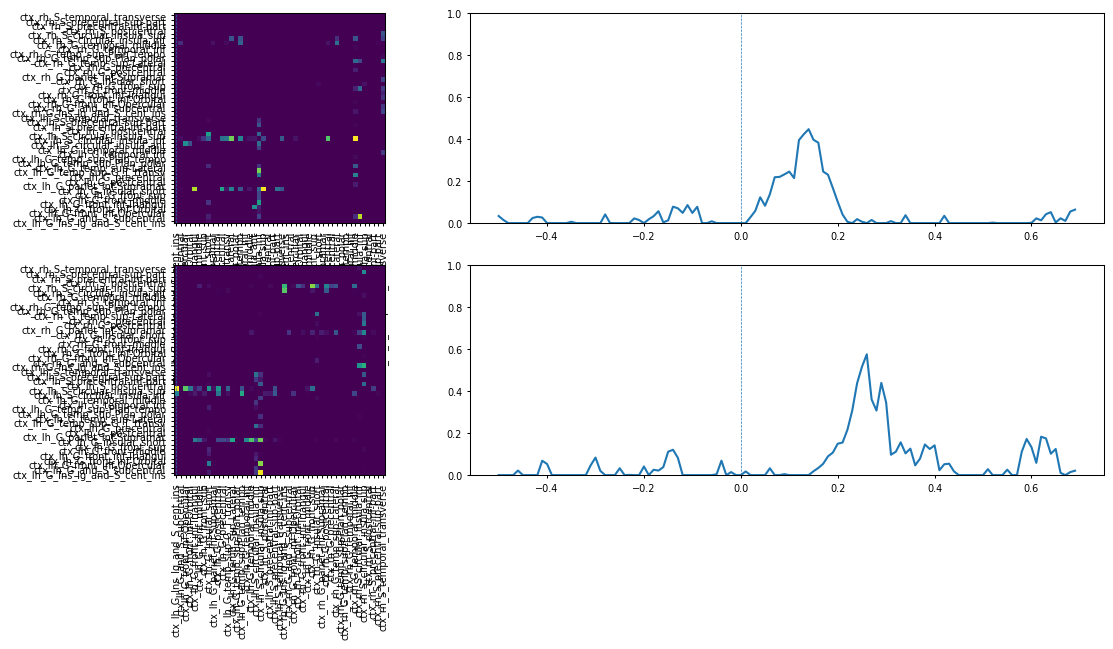

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={"width_ratios": [1, 3]})

i = 2

ax1[0].pcolormesh(
    perception_labels, 
    perception_labels,
    W_perception[..., i]
)

# rotate x axis labels
for label in ax1[0].get_xticklabels():
    label.set_rotation(90)

ax1[1].plot(perception_time, H_perception[i])
ax1[1].set_ylim(0,1)


ax2[0].pcolormesh(
    production_labels, 
    production_labels,
    W_production[..., i]
)

# rotate x axis labels
for label in ax2[0].get_xticklabels():
    label.set_rotation(90)

ax2[1].plot(production_time, H_production[i])
ax2[1].set_ylim(0,1)


for ax in fig.axes:
    ax.tick_params(labelsize=7, width=.75, length=2, which='both',)
    plt.setp(ax.spines.values(), linewidth=.75)
    ax.axvline(0, lw=0.5, ls='dashed')

In [11]:
def validate_connection_across_subjects(
    pdc_df, 
    source_region, 
    target_region, 
    phase='production',
    time_window=(-0.5, 0.7),
    alpha=0.01,
    level='label'  # 'roi' or 'label'
):
    """
    Validate whether a connection exists consistently across multiple subjects.
    
    Parameters
    ----------
    pdc_df : pd.DataFrame
        Original long-format PDC data with subject column
    source_region, target_region : str
        Source and target region names (ROI or label)
    phase : str
        'perception' or 'production'
    time_window : tuple
        Time window
    alpha : float
        Significance threshold
    level : str
        'roi' or 'label'
        
    Returns
    -------
    result : dict
        Dictionary containing statistical results
    """
    from scipy import stats
    
    # Select column names based on level
    if level == 'roi':
        src_col, tgt_col = 'source_roi', 'target_roi'
    else:
        src_col, tgt_col = 'source_label', 'target_label'
    
    # Filter data
    subset = pdc_df[
        (pdc_df['phase'] == phase) &
        (pdc_df[src_col] == source_region) &
        (pdc_df[tgt_col] == target_region) &
        (pdc_df['time'] >= time_window[0]) &
        (pdc_df['time'] <= time_window[1]) &
        (pdc_df['pval'] < alpha)  # Only significant connections
    ].copy()
    
    if subset.empty:
        return None
    
    # Aggregate by subject: mean PDC per subject
    subject_means = subset.groupby('subject')['pdc'].mean()
    
    n_subjects = len(subject_means)
    total_subjects = pdc_df[pdc_df['phase'] == phase]['subject'].nunique()
    
    # Statistical test: is it significantly greater than 0?
    if n_subjects >= 3:
        t_stat, p_value = stats.ttest_1samp(subject_means.values, 0)
        try:
            w_stat, w_pvalue = stats.wilcoxon(subject_means.values, alternative='greater')
        except:
            w_stat, w_pvalue = np.nan, np.nan
    else:
        t_stat, p_value = np.nan, np.nan
        w_stat, w_pvalue = np.nan, np.nan
    
    result = {
        'source': source_region,
        'target': target_region,
        'n_subjects_with_connection': n_subjects,
        'total_subjects': total_subjects,
        'coverage_ratio': n_subjects / total_subjects,
        'mean_pdc': subject_means.mean(),
        'std_pdc': subject_means.std(),
        'min_pdc': subject_means.min(),
        'max_pdc': subject_means.max(),
        't_statistic': t_stat,
        't_pvalue': p_value,
        'wilcoxon_pvalue': w_pvalue,
        'subject_values': subject_means.to_dict()
    }
    
    return result


def validate_top_connections(pdc_df, W, regions_list, component_idx, phase='production', 
                             top_n=5, time_window=(-0.5, 0.7), level='label'):
    """Validate top connections from a specific NMF component across subjects.
    
    Parameters
    ----------
    pdc_df : pd.DataFrame
        Original long-format PDC data
    W : np.ndarray
        NMF spatial weights, shape (n_regions, n_regions, n_components)
    regions_list : list
        List of region names
    component_idx : int
        Which NMF component to analyze
    phase : str
        'perception' or 'production'
    top_n : int
        Number of top connections to validate
    time_window : tuple
        Time window for validation
    level : str
        'roi' or 'label'
        
    Returns
    -------
    results : list of dict
        Validation results for each top connection
    """
    
    flat_conn = W[..., component_idx].flatten()
    top_indices = np.argsort(flat_conn)[-top_n:][::-1]
    
    results = []
    print(f"\n{'='*80}")
    print(f"Validating Component {component_idx} - Top {top_n} Connections ({phase})")
    print(f"{'='*80}")
    
    for rank, conn_idx in enumerate(top_indices):
        roi_i = conn_idx // len(regions_list)
        roi_j = conn_idx % len(regions_list)
        weight = flat_conn[conn_idx]
        
        src_region = regions_list[roi_i]
        tgt_region = regions_list[roi_j]
        
        result = validate_connection_across_subjects(
            pdc_df, src_region, tgt_region, 
            phase=phase, time_window=time_window, level=level
        )
        
        if result:
            results.append(result)
            
            # Print summary
            coverage = result['coverage_ratio']
            n_subj = result['n_subjects_with_connection']
            total = result['total_subjects']
            mean_pdc = result['mean_pdc']
            
            # Determine reliability
            if coverage >= 0.5:
                status = "✅ Reliable"
            elif coverage >= 0.3:
                status = "⚠️ Moderate"
            else:
                status = "❌ Sparse"
            
            print(f"\n{rank+1}. {src_region[:30]} -> {tgt_region[:30]}")
            print(f"   NMF Weight: {weight:.4f}")
            print(f"   Subject Coverage: {n_subj}/{total} ({coverage:.0%}) {status}")
            print(f"   Mean PDC: {mean_pdc:.4f} ± {result['std_pdc']:.4f}")
            if not np.isnan(result['t_pvalue']):
                sig = "✓" if result['t_pvalue'] < 0.05 else "✗"
                print(f"   T-test p-value: {result['t_pvalue']:.4f} {sig}")
        else:
            print(f"\n{rank+1}. {src_region[:30]} -> {tgt_region[:30]}")
            print(f"   NMF Weight: {weight:.4f}")
            print(f"   ⚠️ No significant connections found in raw data")
    
    return results


# Validate production component
print("="*80)
print("PRODUCTION - Component Analysis")
print("="*80)

# Change component_idx to match the one you're visualizing (i from cell 12)
component_to_validate = i  # This should match 'i' from the visualization cell

results_prod = validate_top_connections(
    pdc, W_production, list(production_labels), 
    component_idx=component_to_validate, 
    phase='production', 
    top_n=8, 
    time_window=(-0.5, 0.7), 
    level='label'
)

# Summary table
print(f"\n{'='*80}")
print("SUMMARY")
print(f"{'='*80}")
print(f"{'Connection':<50} {'Coverage':<12} {'Mean PDC':<10} {'Status':<10}")
print("-"*80)
for r in results_prod:
    conn_name = f"{r['source'][:20]} -> {r['target'][:20]}"
    coverage = f"{r['n_subjects_with_connection']}/{r['total_subjects']}"
    status = "Reliable" if r['coverage_ratio'] >= 0.5 else ("Moderate" if r['coverage_ratio'] >= 0.3 else "Sparse")
    print(f"{conn_name:<50} {coverage:<12} {r['mean_pdc']:<10.4f} {status:<10}")

PRODUCTION - Component Analysis

Validating Component 4 - Top 8 Connections (production)

1. ctx_rh_S_circular_insula_sup -> ctx_rh_G_front_sup
   NMF Weight: 0.3842
   Subject Coverage: 4/54 (7%) ❌ Sparse
   Mean PDC: 0.0872 ± 0.0554
   T-test p-value: 0.0514 ✗

2. ctx_lh_G_insular_short -> ctx_lh_G_front_inf-Triangul
   NMF Weight: 0.3512
   Subject Coverage: 2/54 (4%) ❌ Sparse
   Mean PDC: 0.0961 ± 0.0477

3. ctx_rh_S_circular_insula_sup -> ctx_rh_G_temp_sup-Lateral
   NMF Weight: 0.3435
   Subject Coverage: 6/54 (11%) ❌ Sparse
   Mean PDC: 0.0657 ± 0.0330
   T-test p-value: 0.0045 ✓

4. ctx_lh_G_front_inf-Triangul -> ctx_lh_G_insular_short
   NMF Weight: 0.3018
   Subject Coverage: 1/54 (2%) ❌ Sparse
   Mean PDC: 0.1312 ± nan

5. ctx_lh_G_Ins_lg_and_S_cent_ins -> ctx_lh_S_circular_insula_sup
   NMF Weight: 0.2965
   Subject Coverage: 6/54 (11%) ❌ Sparse
   Mean PDC: 0.0812 ± 0.0415
   T-test p-value: 0.0049 ✓

6. ctx_lh_S_circular_insula_sup -> ctx_lh_G_front_inf-Orbital
   NMF Wei

In [ ]:
# 分析组件6的详细连接模式
def analyze_component_detailed(W_component, H_component, labels_list, times, component_idx=6, top_n=10):
    """详细分析特定组件的连接模式"""
    
    print(f"=== 组件 {component_idx} 详细分析 ===")
    
    # 时间动态分析
    h_values = H_component[component_idx, :]
    peak_times_idx = np.argsort(h_values)[-3:][::-1]  # 前3个峰值时间点
    peak_times = times[peak_times_idx]
    peak_values = h_values[peak_times_idx]
    
    print(f"\n时间动态特征:")
    print(f"  最大激活值: {np.max(h_values):.3f}")
    print(f"  平均激活值: {np.mean(h_values):.3f}")
    print(f"  前3个峰值时间点: {peak_times} s")
    print(f"  对应激活值: {peak_values}")
    
    # 空间连接分析
    conn_matrix = W_component[:, :, component_idx]
    
    # 获取top连接
    flat_conn = conn_matrix.flatten()
    top_indices = np.argsort(flat_conn)[-top_n:][::-1]
    
    print(f"\n前{top_n}个最强连接:")
    print("-" * 80)
    print(f"{'排名':<4} {'源区域':<25} {'目标区域':<25} {'连接强度':<10} {'功能类别':<15}")
    print("-" * 80)
    
    # 分析连接的功能类别
    connection_categories = {
        'motor_sensory': [],
        'frontal_temporal': [],
        'insula_related': [],
        'interhemispheric': [],
        'other': []
    }
    
    for idx, conn_idx in enumerate(top_indices):
        roi_i = conn_idx // len(labels_list)
        roi_j = conn_idx % len(labels_list)
        weight = flat_conn[conn_idx]
        
        src_label = labels_list[roi_i]
        tgt_label = labels_list[roi_j]
        
        # 功能分类
        category = 'other'
        if ('G_precentral' in src_label or 'S_precentral' in src_label or 
            'G_precentral' in tgt_label or 'S_precentral' in tgt_label or
            'G_postcentral' in src_label or 'S_postcentral' in src_label or
            'G_postcentral' in tgt_label or 'S_postcentral' in tgt_label):
            category = 'motor_sensory'
        elif ('G_front' in src_label or 'S_front' in src_label or
              'G_front' in tgt_label or 'S_front' in tgt_label):
            if ('temporal' in src_label or 'temporal' in tgt_label):
                category = 'frontal_temporal'
        elif ('insula' in src_label.lower() or 'insula' in tgt_label.lower()):
            category = 'insula_related'
        elif (('lh_' in src_label and 'rh_' in tgt_label) or 
              ('rh_' in src_label and 'lh_' in tgt_label)):
            category = 'interhemispheric'
            
        connection_categories[category].append((src_label, tgt_label, weight))
        
        category_display = {
            'motor_sensory': '运动感觉',
            'frontal_temporal': '额颞连接', 
            'insula_related': '脑岛相关',
            'interhemispheric': '半球间',
            'other': '其他'
        }[category]
        
        print(f"{idx+1:<4} {src_label[:24]:<25} {tgt_label[:24]:<25} {weight:<10.3f} {category_display:<15}")
    
    # 统计功能类别
    print(f"\n功能类别统计:")
    print("-" * 40)
    category_names = {
        'motor_sensory': '运动感觉网络',
        'frontal_temporal': '额颞网络',
        'insula_related': '脑岛网络', 
        'interhemispheric': '半球间连接',
        'other': '其他连接'
    }
    
    for category, connections in connection_categories.items():
        if connections:
            total_weight = sum(w for _, _, w in connections)
            print(f"{category_names[category]}: {len(connections)}个连接, 总权重: {total_weight:.3f}")
    
    return connection_categories

# 分析组件6 
categories = analyze_component_detailed(W_perception, H_perception, perception_labels, perception_time, component_idx=i)
# categories = analyze_component_detailed(W_production, H_production, production_labels, production_time, component_idx=i)

=== 组件 4 详细分析 ===

时间动态特征:
  最大激活值: 0.391
  平均激活值: 0.049
  前3个峰值时间点: [-0.21 -0.22 -0.2 ] s
  对应激活值: [0.39136624 0.38663929 0.37658423]

前10个最强连接:
--------------------------------------------------------------------------------
排名   源区域                       目标区域                      连接强度       功能类别           
--------------------------------------------------------------------------------
1    ctx_lh_G_front_inf-Orbit  ctx_lh_S_circular_insula  0.505      其他             
2    ctx_lh_S_precentral-sup-  ctx_lh_S_circular_insula  0.393      运动感觉           
3    ctx_lh_G_and_S_subcentra  ctx_rh_G_temporal_middle  0.339      半球间            
4    ctx_lh_G_insular_short    ctx_lh_S_circular_insula  0.308      脑岛相关           
5    ctx_lh_S_precentral-sup-  ctx_lh_S_circular_insula  0.254      运动感觉           
6    ctx_lh_G_front_inf-Trian  ctx_lh_G_insular_short    0.235      其他             
7    ctx_lh_G_front_inf-Trian  ctx_lh_S_circular_insula  0.228      其他             
8    ctx_lh_S_circul